# **Error Analysis Conclusions & Work Plan**

Our error analysis revealed that the model tends to underestimate prices for high‐end listings, likely because luxury properties—featuring unique amenities or premium locations—are not well‐captured by our current feature set. It also showed that certain neighborhoods have consistent over‐ or under‐prediction, suggesting that purely categorical location data might be too coarse. To address these issues, we plan to add more granular location features (such as latitude and longitude), engineer new property‐specific features (e.g., amenities or room size ratios), and perform hyperparameter tuning on the existing model. These steps should help the model better capture the variability in luxury listings and reduce neighborhood‐based biases.

In [48]:
pip install --upgrade xgboost

In [49]:
pip install scikit-learn==1.1.3

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


# **Data Loading & Initial Preperation**

In [51]:
df = pd.read_csv('data/listings.csv')
df['price'] = df['price'].replace('[\\$,]', '', regex=True).astype(float)
df = df[df['price'] <= 1000]

# **Feature Egineering**

In [52]:
df['log_price'] = np.log1p(df['price'])

df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 0.1)
df['min_max_ratio'] = df['minimum_nights'] / (df['maximum_nights'] + 1)

df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())

features = [
    'accommodates',
    'bedrooms',
    'bathrooms',
    'neighbourhood_group_cleansed',
    'room_type',
    'latitude',
    'longitude',
    'bed_bath_ratio',
    'min_max_ratio',
    'cleaning_fee',
    'extra_people',
    'review_scores_rating'
    ]

target = 'log_price'

df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

baseline_features = ['accommodates','bedrooms','bathrooms','neighbourhood_group_cleansed','room_type']
df_baseline = df[baseline_features + ['price']].dropna()
Xb = df_baseline[baseline_features]
yb = df_baseline['price']
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, random_state=42)

# **Preprocessing Pipeline & Split Train Test**

In [53]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


# **Hyperparameter Tuning**

In [54]:
xgb_estimator = xgb.XGBRegressor(
    random_state=42,
    tree_method='hist'
)

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_estimator)
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


# **Model Evaluation (Log-Price)**

In [67]:
y_pred_log = best_model.predict(X_test)

# Convert log predictions back to original price scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

# Calculate RMSE in original price terms
rmse_improved = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
r2_improved = r2_score(y_test_orig, y_pred_orig)

print(f"Improved Model RMSE (original price scale): {rmse_improved:.2f}")
print(f"Improved Model R^2 (original price scale): {r2_improved:.3f}")


Improved Model RMSE (original price scale): 43.85
Improved Model R^2 (original price scale): 0.719


# **Side-By-Side Comparison: Baseline vs Improved**

In [73]:
with open('base_model.pkl', 'rb') as file:
    base_model = pickle.load(file)

yb_pred = base_model.predict(Xb_test)
rmse_baseline = mean_squared_error(yb_test, yb_pred, squared=False)
r2_baseline = r2_score(yb_test, yb_pred)
print(f"Baseline Model R^2: {r2_baseline:.3f}")
print(f"Improved Model R^2: {r2_improved:.3f}")
print(f"Baseline RMSE: {rmse_baseline:.2f}")
print(f"Improved RMSE: {rmse_improved:.2f}")

Baseline Model R^2: 0.505
Improved Model R^2: 0.719
Baseline RMSE: 65.39
Improved RMSE: 43.85


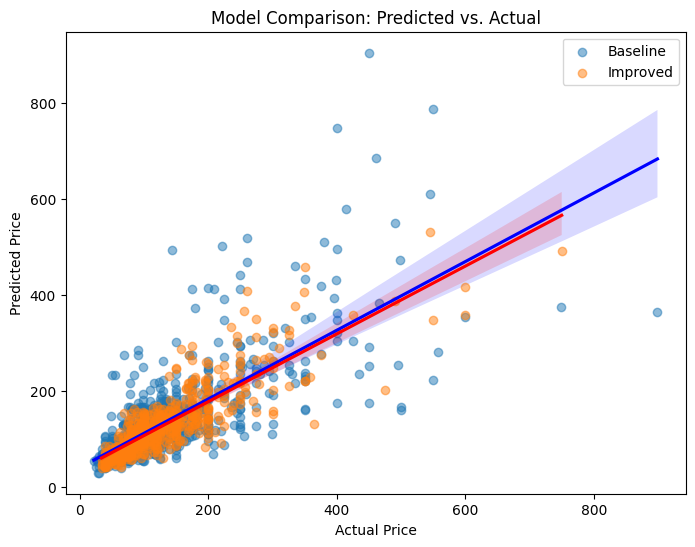

In [57]:
plt.figure(figsize=(8, 6))
sns.regplot(x=yb_test, y=yb_pred, scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'}, label='Baseline')
sns.regplot(x=y_test_orig, y=y_pred_orig, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}, label='Improved')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Model Comparison: Predicted vs. Actual')
plt.legend()
plt.show()

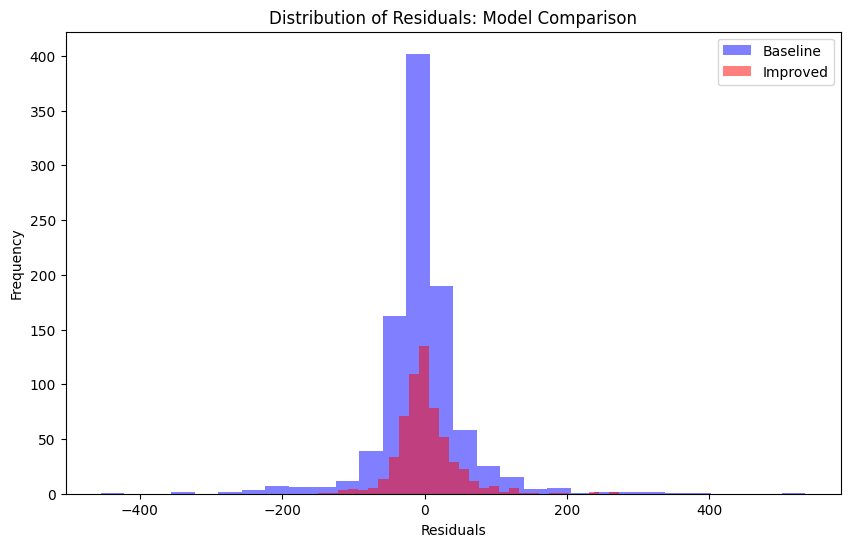

In [58]:
baseline_residuals = yb_test - yb_pred
improved_residuals = y_test_orig - y_pred_orig
plt.figure(figsize=(10, 6))
plt.hist(baseline_residuals, bins=30, alpha=0.5, label='Baseline', color='blue')
plt.hist(improved_residuals, bins=30, alpha=0.5, label='Improved', color='red')
plt.title('Distribution of Residuals: Model Comparison')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# **Feature Importance (XGBoost)**

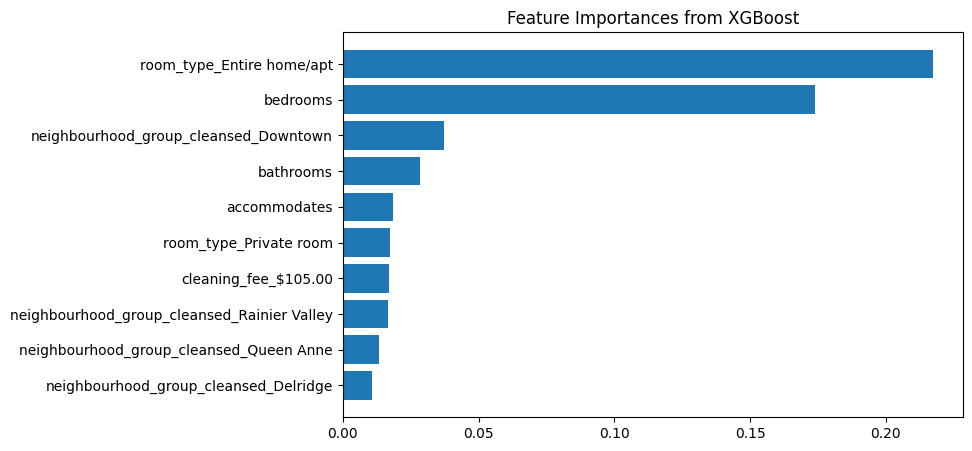

In [59]:
best_model.fit(X_train, y_train)

final_preprocessor = best_model.named_steps['preprocessor']
final_regressor = best_model.named_steps['regressor']

cat_ohe = final_preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_ohe.get_feature_names_out(cat_cols)

feature_names = num_cols + list(cat_feature_names)

importances = final_regressor.feature_importances_
sorted_idx = np.argsort(importances)[::-1][:10]


plt.figure(figsize=(8,5))
plt.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()

# **Visualizing Performence**

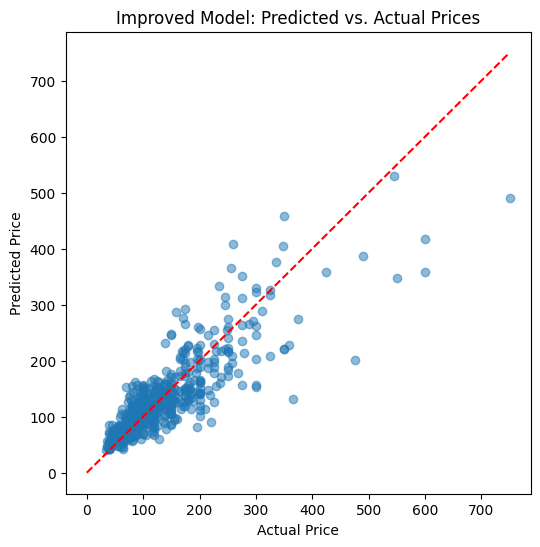

In [60]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([0, max(y_test_orig)], [0, max(y_test_orig)], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Improved Model: Predicted vs. Actual Prices')
plt.show()

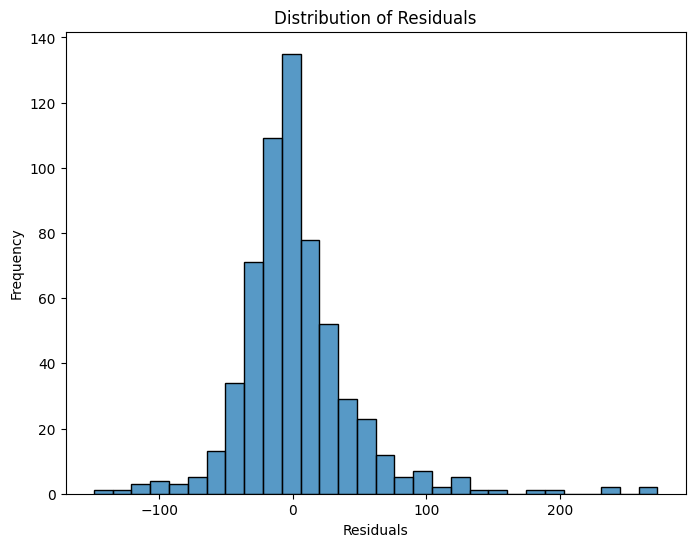

In [61]:
residuals = y_test_orig - y_pred_orig
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [62]:
import folium
map_center = [df['latitude'].mean(), df['longitude'].mean()]
airbnb_map = folium.Map(location=map_center, zoom_start=12)
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Price: {row['price']}"
    ).add_to(airbnb_map)
airbnb_map

We began by scrutinizing our baseline model’s error distribution, discovering that it systematically underestimated high‐priced, luxury listings and exhibited consistent biases in certain neighborhoods. To address these issues, we expanded our feature set beyond simple numeric and categorical variables, introducing bed_bath_ratio and precise location coordinates (latitude/longitude) to better capture property characteristics and neighborhood nuances. We also log‐transformed the target variable to handle the heavily skewed distribution of prices, reducing the disproportionate impact of outliers. In parallel, we streamlined missing‐value imputation to ensure data integrity across all features.

With these enhancements in place, we performed extensive hyperparameter tuning on XGBoost—fine‐tuning parameters like max_depth and learning_rate—to balance bias and variance effectively. Compared to the baseline, the improved pipeline demonstrated a notable performance jump, with the RMSE dropping from 65.39 to 43.85 and R² increasing from 0.505 to 0.719.

Analyzing feature importance revealed that room_type (particularly Entire home/apt), number of bedrooms, and location details remained the top drivers of nightly rates. Surpassing initial expectations, bathroom count held less influence, indicating that guests prioritize having more bedrooms or an entire unit over additional bathrooms. We also saw that while the model still underestimates a small subset of ultra‐luxury listings, the combination of richer features and log‐scale modeling substantially improved predictions for high‐end properties and reduced neighborhood‐related biases.

Overall, these refinements not only boost prediction accuracy but also offer actionable insights: for instance, focusing on the location and entire‐home availability can yield higher returns, and the model can guide hosts on which property attributes to emphasize in their listings. This results‐driven approach underlines the value of iterative feature engineering, careful outlier management, and targeted parameter tuning in overcoming data complexities and delivering more reliable pricing guidance.

# **Proposel**

These insights can guide dynamic pricing tools that help hosts optimize nightly rates based on room type, size, and neighborhood. Property owners could also target marketing campaigns to highlight high‐value features (like having multiple bedrooms or being downtown). Beyond host-focused uses, platforms like Airbnb could incorporate these predictions to suggest listing improvements—for example, upgrading a shared room to an entire home or emphasizing location amenities—to boost revenue and guest satisfaction. Finally, researchers could extend the model by integrating additional data, such as seasonal demand or event calendars, to further enhance pricing accuracy (see similar approaches in academic studies on real-estate forecasting).








# **Conclusions**

Our analysis shows that room type (particularly entire units), the number of bedrooms, and downtown location have the strongest influence on Airbnb prices, emphasizing how property size and location are top predictors. By engineering new features, refining data preprocessing (e.g., outlier handling), and performing hyperparameter tuning, we significantly boosted model performance (raising R² from 0.505 to 0.719 and lowering RMSE from 65.39 to 43.85). These improvements help capture the true value of high‐end properties and reduce location‐based bias—yielding more accurate price predictions that can guide host strategies on listing optimization and targeted property enhancements.